# Estimacion de Precios de Vehiculos

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.metrics import root_mean_squared_error
import statistics
import time
import re

In [2]:
# Descargar datos
data = pd.read_csv('dataset/car_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Descripción de los datos**

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

Algunos de los datos como `DateCrawled`, `DateCreated`, `NumberOfPictures` , `LastSeen` y `PostalCode` parecen ser poco relevantes a la hora de fijar el precio de un vehiculo. Quizas sean importantes para saber la vigencia de la publicacion o la autenticidad de esta pero para este analisis podiran entorpecer los modelos y estorban visualmente, distraen de las columnas relevantes. 

Además el dataset tiene muchos errores, que podrian generar problemas durante el análisis o el entrenamiento de los modelos:
- Las columnas estan nombradas con estilo CamelCase, por convension sera mejor cambiarlo a Snake_case.
- Se identificaron varias columnas con valores ausentes, lo conveniente seria revisarlas individualmente.
- La mayoria de las columnas tienen datos de tipo `object` por lo que seria conveniente codificarlas

In [5]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


En la tabla anterior se identifican varios problemas en los datos:

- ***`Price`*** : No es lógico ni factible que el precio de un vehículo sea 0 euros. Además, precios inferiores a 500 euros son poco realistas, ya que es improbable que vehículos usados en condiciones aceptables estén en ese rango. Es probable que estos registros correspondan a anuncios donde el precio fue ingresado como un valor simbólico o temporal, debido a que el precio final sería negociable con el vendedor. Dado que esta columna es el objetivo de los modelos, lo más conveniente será eliminar los registros con valores dudosos para evitar que interfieran negativamente en las estadísticas o en el entrenamiento de los modelos.


- ***`RegistrationYear`***: Los valores mínimo y máximo de esta columna carecen de sentido lógico. Los vehículos motorizados no existían antes de 1886, y un año como 9999 está demasiado lejos en el futuro. Para corregir esto, se investigará la antigüedad de los modelos presentes en el conjunto de datos, estableciendo como valor mínimo el año del vehículo más antiguo registrado y como valor máximo el año actual.


- ***`Power`***: Tras analizar el rango lógico de potencia para vehículos convencionales, se determinó que oscila entre 30 y 650 CV. Valores de 0 o superiores a 1000 CV son poco realistas y probablemente resultan de errores de registro o entrada de datos incorrectos. Además, no representan una proporción significativa de los datos, ya que el 75% de los valores se encuentran por debajo de 143 CV, lo cual refuerza esta conclusión.


- ***`RegistrationMonth:`*** El único valor fuera de rango en esta columna es 0. Es probable que estos registros representen valores ausentes, ya que no es posible que un mes de registro sea 0. Por lo tanto, se considerará este valor como nulo para su tratamiento en el análisis.

La columna ***`Mileage`*** parece lógico y factible considerando que se trata de vehiculos de segunda mano.
Las columnas ***`NumberOfPictures`*** y ***`PostalCode`*** no son relevantes.

In [6]:
# Renombrar columnas de CamelCase a snake_case
new_columns = []
for column in data.columns:
    snake_name = re.sub(r'([a-z])([A-Z])', r'\1_\2', column).lower()
    new_columns.append(snake_name)
data.columns = new_columns

In [7]:
# Verificar y eliminar datos duplicados
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

262


Se encontraron algunos datos duplicados, el conjunto de datos ya es grande con más de 350.000 datos, eliminar 262 duplicados no afecta negativamente la diversidad de los datos.

A contiacion se revisará los valores de las columnas importantes del dataset pera verificar que los valores se encuentren en rangos lógicos y que las columnas de caracteristicas categoricas no tengan duplicados implisitos u otros errores que puedan dificultar o entorpecer el entrenamiento de los modelos de Machine Learning (ML)
###  Precio (price)

In [8]:
# Funcion para verificar el porcentaje de datos nulos
full_data = data.shape[0]
def percent_null(data):
    data_null= (data/full_data)*100
    print('Porcentaje de datos nulos: {:.2f}%'.format(data_null))
    return data_null

In [9]:
# Definir el umbral mínimo de precio
min_price = 200
# Calcular el número y porcentaje de filas con price fuera de rango
lowest_price = data[data['price'] < min_price].shape[0]
print(f"Filas con price = 0: {lowest_price}")
price_null= percent_null(lowest_price)

Filas con price = 0: 17458
Porcentaje de datos nulos: 4.93%


En lugar de eliminar los datos ilogicos directamente, se reemplazaran con valores nulos, para verificar el total de datos que se eliminaran del dataset

In [10]:
# Filtrar valores irreales
data.loc[data['price'] < min_price, 'price']=np.nan
# Verificar la distribución después del filtro
print(data['price'].describe())

count    336649.000000
mean       4643.501947
std        4515.536595
min         200.000000
25%        1250.000000
50%        2950.000000
75%        6650.000000
max       20000.000000
Name: price, dtype: float64


### Año  de Registro (registration_year)

In [11]:
# Verificar el rango lógico de los años
min_year, max_year = 1964, 2024  # Ajustar el año máximo al actual
invalid_years = data[(data['registration_year'] < min_year) | (data['registration_year'] > max_year)]
print(f"Total de valores fuera de rango: {invalid_years.shape[0]}")
print(invalid_years['registration_year'].unique())
year_null= percent_null(invalid_years.shape[0])

Total de valores fuera de rango: 859
[1910 1111 1945 1925 1955 1961 1960 1963 5000 1954 1958 1959 9999 1956
 3200 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
Porcentaje de datos nulos: 0.24%


Algunos registros tienen valores fuera de rango lógico la columna `registration_year`, como el porcentaje que ocupan es pequeño lo más facíl es eliminarlos

In [12]:
data.loc[(data['registration_year'] < min_year) | (data['registration_year'] > max_year),'registration_year']= np.nan
print(data['registration_year'].unique())

[1993. 2011. 2004. 2001. 2008. 1995. 1980. 2014. 1998. 2005.   nan 2016.
 2007. 2009. 2002. 2018. 1997. 1990. 2017. 1981. 2003. 1994. 1991. 1984.
 2006. 1999. 2012. 2010. 2000. 1992. 2013. 1996. 1985. 1989. 2015. 1982.
 1976. 1983. 1973. 1969. 1971. 1987. 1986. 1988. 1970. 1965. 1974. 1979.
 1978. 1972. 1968. 1977. 1966. 1975. 1964. 1967. 2019.]


### Mes de Registro (registration_month)

In [13]:
print(data['registration_month'].value_counts())

registration_month
0     37347
3     34348
6     31471
4     29246
5     29131
7     27186
10    26076
12    24271
11    24167
9     23798
1     23202
8     22610
2     21254
Name: count, dtype: int64


Se identificaron varias filas donde `registration_month` tiene un valor de 0. Dado que esta característica parece menos relevante a la hora de determinar el precio de un vehículo en comparación con `registration_year`, reemplazaremos estos valores con la moda correspondiente, permitiendo así conservar estos registros en el conjunto de datos.

In [14]:
mode_month = data['registration_month'].mode().iloc[0]
# Corregir valores fuera del rango asignándoles 1
data.loc[data['registration_month'] < 1] = mode_month

print(data['registration_month'].value_counts())

registration_month
0     37347
3     34348
6     31471
4     29246
5     29131
7     27186
10    26076
12    24271
11    24167
9     23798
1     23202
8     22610
2     21254
Name: count, dtype: int64


### Marca (brand)

In [15]:
# verificar la cantidad de marcas 
brands = data['brand'].unique()
n_brands = data['brand'].nunique()
print('Cantidad de Marcas:',n_brands,'\n', brands)

Cantidad de Marcas: 41 
 [0 'audi' 'jeep' 'volkswagen' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'subaru' 'volvo' 'mitsubishi'
 'alfa_romeo' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'rover' 'porsche'
 'daewoo' 'land_rover' 'lada']


El dataset tiene una gran variedad de marcas de auto, lo cual puede resultar un poco exesivo para los modelos a la hora de codificar esta columna con cualquier metodo ya sea OneHotEncoding o LabelEncoding. La mejor opción para reducir la cantidad de marcas sin perjudicar el entrenamiento de modelos es agruparlos.

In [16]:
# Diccionario de marcas agrupadas
brand_map = {
    'volkswagen': 'Volkswagen Group',
    'audi': 'Volkswagen Group',
    'jeep': 'Jeep',
    'skoda': 'Volkswagen Group',
    'bmw': 'BMW Group',
    'peugeot': 'Stellantis',
    'ford': 'Ford',
    'mazda': 'Marcas japonesas',
    'nissan': 'Renault Group',
    'renault': 'Renault Group',
    'mercedes_benz': 'Mercedes-Benz Group',
    'opel': 'Stellantis',
    'seat': 'Volkswagen Group',
    'citroen': 'Stellantis',
    'honda': 'Honda',
    'fiat': 'Stellantis',
    'mini': 'BMW Group',
    'smart': 'Mercedes-Benz Group',
    'hyundai': 'Hyundai',
    'sonstige_autos': 'Otros',
    'alfa_romeo': 'Stellantis',
    'subaru': 'Marcas japonesas',
    'volvo': 'Volvo',
    'mitsubishi': 'Marcas japonesas',
    'kia': 'Kia',
    'suzuki': 'Marcas japonesas',
    'lancia': 'Stellantis',
    'toyota': 'Toyota',
    'chevrolet': 'General Motors',
    'dacia': 'Renault Group',
    'daihatsu': 'Marcas japonesas',
    'trabant': 'Trabant',
    'chrysler': 'Chrysler',
    'jaguar': 'Tata Motors',
    'daewoo': 'General Motors',
    'porsche': 'Volkswagen Group',
    'rover': 'Tata Motors',
    'saab': 'Saab',
    'land_rover': 'Tata Motors',
    'lada': 'Lada'
}

# Aplicar mapeo de marcas
data['brand'] = data['brand'].map(brand_map)

### Columna Modelo (model)

In [17]:
car_models= data['model'].unique().astype('str')
car_models.sort()
n_car_models = data['model'].nunique()
print(n_car_models,'\n', car_models)

250 
 ['0' '100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand' 'i3' 'i_reihe' 'ibiza'
 '

Algunos modelos están registrados más de una vez bajo diferentes nombres y la cantidad de modelos existentes en el dataset poría dificultar el entrenamiento de los modelos de ML o producir errores en sus calculos.

In [18]:
def replace_values(data, column, wrong_values_map):
    # wrong_values_map debe ser un diccionario donde las claves son las variantes incorrectas
    # y los valores son las versiones correctas a usar.
    for wrong_value, correct_value in wrong_values_map.items(): 
        data[column].replace(wrong_value, correct_value, inplace=True)
    return data

# Crear un diccionario con las variantes incorrectas y sus nombres correctos
wrong_models_map = {
    '1_reihe': 'serie_1', '1er': 'serie_1',
    '2_reihe': 'serie_2', '2er': 'serie_2',
    '3_reihe': 'serie_3', '3er': 'serie_3',
    '4_reihe': 'serie_4', '4er': 'serie_4',
    '5_reihe': 'serie_5', '5er': 'serie_5',
    '6_reihe': 'serie_6', '6er': 'serie_6',
    '7er': 'serie_7',
    'range_rover': 'range_rover', 
    'range_rover_evoque': 'range_rover', 
    'range_rover_sport': 'range_rover',
    'rangerover': 'range_rover'
}

# Llamar a la función para agrupar los modelos en la columna 'model'
data = replace_values(data, 'model', wrong_models_map)

In [19]:
# Verificar porcentaje de model nulos
percent_null(data['model'].isna().sum())

Porcentaje de datos nulos: 3.72%


3.7169556094626763

Los registros sin datos en la columna `model` serán eliminados ya que no hay un metodo fiable para imputar valores sin el riesgo de que implique errores considerables en los modelos de ML.
Además se identificó una gran cantidad de modelos de vehículos diferentes, lo que podría dificultar el manejo por parte de los modelos de Machine Learning. Para simplificar el análisis, se agruparán los modelos que representen menos del 3% de los datos en la categoría 'otros' (others). Este paso se realizara al concluir la imputacion de valores para los datos nulos, ya que el modelo es un atributo de gran relevancia para determinar datos como el tipo de vehiculo, el tipo de combustible o la potencia

### Tipo de Vehiculo (vehicle_type)

In [20]:
data['vehicle_type'].unique()

array([0, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [21]:
data['vehicle_type'] = data['vehicle_type'].replace(0, np.nan)

In [22]:
# Verificar porcentaje de datos con vehicle_type nulos
percent_null(data['vehicle_type'].isna().sum())

Porcentaje de datos nulos: 16.92%


16.920591798524175

La proporcion de datos con `vehicle_type` nulos es superior al 10%, pero este dato se puede inferir con respecto a la información de la  marca y el modelo si lo comparamos con otros registros de similares caracteristicas.

In [23]:
vehicle_type_map = data.groupby(['brand', 'model'])['vehicle_type'].agg(lambda x: x.mode()[0]
                                                                      if not x.mode().empty else None).to_dict()

def infer_vehicle_type(row):
    return vehicle_type_map.get((row['brand'], row['model']), None)

data['vehicle_type'] = data.apply(
    lambda row: infer_vehicle_type(row) if pd.isnull(row['vehicle_type']) else row['vehicle_type'], axis=1
)
percent_null(data['vehicle_type'].isna().sum())

Porcentaje de datos nulos: 11.45%


11.447104971096307

Se redujo el porcentaje de datos nulos en `vehicle_type`. Es recomendable eliminar los datos restantes

### Potencia (power)

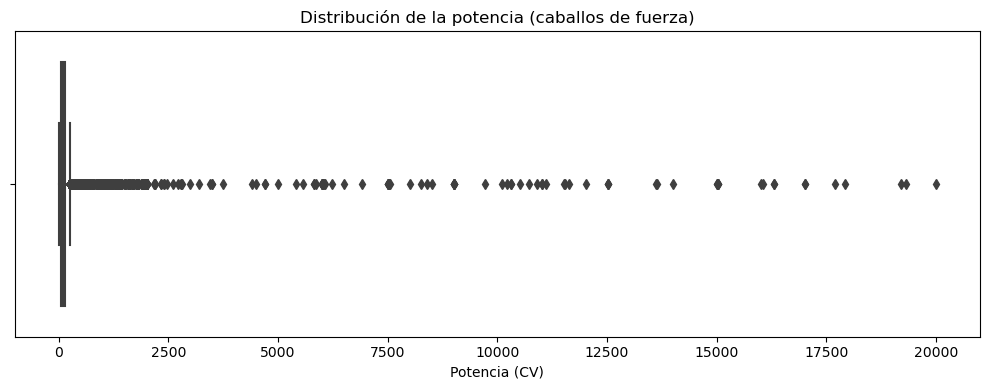

In [24]:
# Crear el boxplot para la columna 'power'
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['power'])

# Añadir título y etiquetas
plt.title('Distribución de la potencia (caballos de fuerza)')
plt.xlabel('Potencia (CV)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Tras investigar el rango factible o lógico de potencia para vehículos convencionales, como los representados en este dataset (excluyendo autos de carrera o de colección antiguos), se concluyó que varía entre 30 y 650 CV. Por lo tanto, se decidió descartar los valores que exceden este rango que además segun el gráfico son valores atípicos (no representan gran proporcion de los datos).

A continuación, se verificará la media de los grupos que se utilizarán para reemplazar los valores fuera de rango, con el objetivo de controlar si esta varía después de la imputación de los valores.

In [25]:
mean_power = data.groupby(['vehicle_type', 'model', 'registration_year', 'brand'])['power'].mean()
mean_power.tail(10)

vehicle_type  model   registration_year  brand     
wagon         zafira  2003.0             Stellantis     90.888889
                      2004.0             Stellantis    108.222222
                      2005.0             Stellantis     72.594595
                      2006.0             Stellantis    135.850000
                      2007.0             Stellantis     86.562500
                      2008.0             Stellantis    137.142857
                      2009.0             Stellantis    140.000000
                      2010.0             Stellantis    141.666667
                      2011.0             Stellantis    158.888889
                      2012.0             Stellantis    165.000000
Name: power, dtype: float64

In [26]:
# Filtrando valores fuera del rango de potencia
min_power, max_power = 30, 600
data.loc[(data['power'] < min_power)|(data['power']>max_power), 'power']= np.nan
percent_null(data['power'].isna().sum())

Porcentaje de datos nulos: 17.88%


17.883295162196738

Dada la distribución de los datos y la gran cantidad de valores atípicos, se optará por utilizar la moda de grupos de vehículos con características similares para reemplazar algunos valores fuera de rango en la columna `power`. Si no se encuentran vehículos con características similares, se asignará un valor nulo.

In [27]:
# Crear un DataFrame auxiliar con la moda para cada grupo
grouped_modes = (
    data.groupby(['vehicle_type', 'model', 'registration_year', 'brand'])['power']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .reset_index()
    .rename(columns={'power': 'power_mode'})
)

# Unir las modas al DataFrame original
data = data.merge(grouped_modes, on=['vehicle_type', 'model', 'registration_year', 'brand'], how='left')

# Reemplazar valores fuera de rango con la moda del grupo
data.loc[data['power'].isna(), 'power'] = data['power_mode']

# Eliminar la columna auxiliar 'power_mode'
data.drop(columns=['power_mode'], inplace=True)

# Verificar si quedan valores nulos
print(percent_null(data['power'].isnull().sum()))

Porcentaje de datos nulos: 11.67%
11.672178183430432


In [28]:
mean_power = data.groupby(['vehicle_type', 'model', 'registration_year', 'brand'])['power'].mean()
mean_power.tail(10)

vehicle_type  model   registration_year  brand     
wagon         zafira  2003.0             Stellantis    118.666667
                      2004.0             Stellantis    122.111111
                      2005.0             Stellantis    116.270270
                      2006.0             Stellantis    143.350000
                      2007.0             Stellantis    124.062500
                      2008.0             Stellantis    137.142857
                      2009.0             Stellantis    140.000000
                      2010.0             Stellantis    141.666667
                      2011.0             Stellantis    165.000000
                      2012.0             Stellantis    165.000000
Name: power, dtype: float64

Se observa una variación en la media de algunos grupos, mientras que otros permanecen sin cambios. Este comportamiento se explica porque únicamente los grupos con valores de potencia fuera del rango establecido se vieron afectados por el tratamiento aplicado. Las variaciones en la media son coherentes y esperables, ya que al reemplazar los valores atípicos o nulos con la moda grupal, los datos tienden a centrarse alrededor de valores representativos de cada grupo.

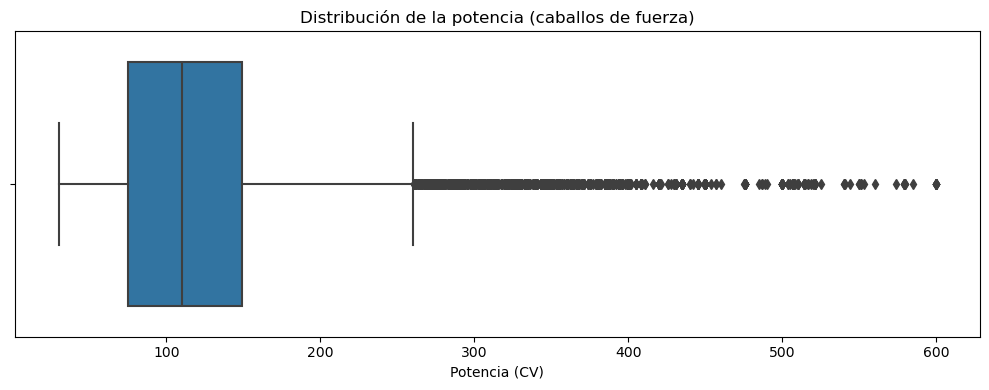

In [29]:
# Crear el boxplot para la columna 'power'
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['power'])

# Añadir título y etiquetas
plt.title('Distribución de la potencia (caballos de fuerza)')
plt.xlabel('Potencia (CV)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

La distribución de los datos de potencia se muestra más clara y consistente tras el tratamiento aplicado. Aunque persisten numerosos valores atípicos, es probable que estos representen datos reales, ya que los vehículos con potencias más altas suelen ser menos comunes debido a su costo elevado. Además, considerando que la empresa se dedica a la venta de autos usados, es posible que su público objetivo esté compuesto mayoritariamente por consumidores de clase media o media baja, lo que explicaría la predominancia de vehículos con potencias más moderadas.

### Tipo de Combustible (fuel_type)

In [30]:
data['fuel_type'].unique()

array([0, 'gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [31]:
data['fuel_type'] = data['fuel_type'].replace({'gasoline': 'petrol', 0 : np.nan})

In [32]:
# Verificar porcentaje de valores ausentes
percent_null(data['fuel_type'].isna().sum())

Porcentaje de datos nulos: 15.98%


15.98443408348324

Considerando el porcentaje de valores ausentes en la columna `fuel_type` parece razonable imputarles el valor de datos con caracteristicas similares de `vehicle_type`, `model` y `brand`, 

In [33]:
# Crear el diccionario para inferir fuel_type
fuel_type_map = data.groupby(['vehicle_type', 'brand', 'model'])['fuel_type'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
).to_dict()

# Definir la función para inferir fuel_type
def infer_fuel_type(row):
    return fuel_type_map.get((row['vehicle_type'], row['brand'], row['model']), np.nan)

# Aplicar la función a la columna fuel_type
data['fuel_type'] = data.apply(
    lambda row: infer_fuel_type(row) if pd.isnull(row['fuel_type']) else row['fuel_type'], axis=1
)

percent_null(data['fuel_type'].isna().sum())

Porcentaje de datos nulos: 11.51%


11.506973880776151

### Sin Reparacion (not_repaired)

In [34]:
percent_null(data['not_repaired'].isna().sum())

Porcentaje de datos nulos: 13.85%


13.852592577949602

Los valores nulos en la columna not_repaired tienen una connotación diferente a las otras columnas, ya que pueden indicar que no se dispone de información sobre si el vehículo requiere reparación. Dado que esta característica no puede inferirse de otras columnas, una solución adecuada sería tratarlos como una tercera categoría denominada 'unknown', diferenciándolos de las opciones 'yes' y 'no'.

In [35]:
# Reemplazar valores NaN en la columna not_repaired
data['not_repaired'] = data['not_repaired'].fillna('unknown')
# Reemplazar valores NaN en la columna not_repaired
percent_null(data['not_repaired'].isna().sum())

Porcentaje de datos nulos: 0.00%


0.0

### Caja de Cambios (gearbox)

In [36]:
percent_null(data['gearbox'].isna().sum())

Porcentaje de datos nulos: 2.84%


2.8417964061710164

La informacion de la **Caja de Cambio (gearbox)** se puede inferir según las caracteristicas de vehiculos similares, considerando que solo existen 2 posibles valores esta imputacion podria ser más certera con un modelo KNN o un Arbol de Decisión para cualquiera de las dos opciones primero se debe codificar las columnas categoricas, ya que hay que hacerlo de todas maneras para entrenar a los modelos para predecir los precios de los vehiculos lo mejor será codificar todas las columnas categoricas, dejando fuera solo `gearbox` para afectar los resultados, esta columna se codificará posteriormente de la imputacion de valores.

In [37]:
data = data.dropna(subset=['model', 'fuel_type', 'vehicle_type','power', 'price','registration_year'])

In [38]:
# Calcular el porcentaje de registros por modelo
model_percent=(data['model'].value_counts()/data.shape[0])*100

# Obtener los modelos con menos del 2% de registros
other = model_percent[model_percent < 2].index.tolist()

# Asignar 'other' a esos modelos
data['model'] = data['model'].replace(other, 'other')

# Verificar el resultado
print(data['model'].value_counts())

model
other       178351
golf         24986
serie_3      20579
polo         10874
corsa        10335
astra         9227
passat        8890
a4            8845
c_klasse      7675
serie_5       7584
e_klasse      6154
Name: count, dtype: int64


**Codificacion de columnas categóricas**

In [39]:
from sklearn.preprocessing import LabelEncoder

data = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

# Crear una copia del dataset original para no modificarlo directamente
encoded_data = data.copy()

# Listado de columnas categóricas a codificar
columns_to_encode = ['brand', 'model', 'fuel_type', 'vehicle_type', 'not_repaired']

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Codificar las columnas categóricas
for col in columns_to_encode:
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col].astype(str))

# Mostrar las primeras filas del dataset codificado
print(encoded_data.head())

    price  vehicle_type  registration_year gearbox  power  model  mileage  \
2  9800.0             6             2004.0    auto  163.0      6   125000   
3  1500.0             5             2001.0  manual   75.0      5   150000   
4  3600.0             5             2008.0  manual   69.0      6    90000   
5   650.0             4             1995.0  manual  102.0      9   150000   
6  2200.0             1             2004.0  manual  109.0      6   150000   

   registration_month  fuel_type  brand  not_repaired  
2                   8          5      6             1  
3                   6          5     17             0  
4                   7          5     17             0  
5                  10          5      0             2  
6                   8          5     13             0  


In [40]:
# Filtrar datos completos para entrenar el modelo
train_data = encoded_data[encoded_data['gearbox'].notna()]
test_data = encoded_data[encoded_data['gearbox'].isna()]

# Usar características relevantes para imputar
features = ['registration_year', 'model', 'brand', 'vehicle_type']
X_train = train_data[features]
y_train = train_data['gearbox']

# Entrenar el modelo
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Predecir los valores faltantes
X_test = test_data[features]
encoded_data.loc[encoded_data['gearbox'].isna(), 'gearbox'] = model.predict(X_test)
percent_null(encoded_data['gearbox'].isna().sum())

Porcentaje de datos nulos: 0.00%


0.0

Finalmente se codifica la columna `gearbox` para entrenar los modelos de ML

In [41]:
encoded_data['gearbox']= label_encoder.fit_transform(encoded_data['gearbox'].astype('str'))
encoded_data.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
2,9800.0,6,2004.0,0,163.0,6,125000,8,5,6,1
3,1500.0,5,2001.0,1,75.0,5,150000,6,5,17,0
4,3600.0,5,2008.0,1,69.0,6,90000,7,5,17,0


In [42]:
# Verificar nuevamente las estadisticas para descartar errores
encoded_data.describe()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
count,293500.000000,293500.000000,293500.00000,293500.000000,293500.000000,293500.000000,293500.000000,293500.000000,293500.000000,293500.000000,293500.000000
mean,4904.647032,4.258627,2003.52369,0.797813,120.180051,5.742784,128401.873935,6.402460,4.957816,11.213700,0.319976
std,4585.149351,2.108642,6.54786,0.401632,52.858418,1.982924,36480.513563,3.349842,0.334077,5.972405,0.630776
min,200.000000,0.000000,1964.00000,0.000000,30.000000,0.000000,5000.000000,1.000000,0.000000,0.000000,0.000000
25%,1400.000000,4.000000,1999.00000,1.000000,75.000000,6.000000,125000.000000,4.000000,5.000000,9.000000,0.000000
50%,3230.000000,4.000000,2004.00000,1.000000,110.000000,6.000000,150000.000000,6.000000,5.000000,13.000000,0.000000
75%,6999.000000,5.000000,2008.00000,1.000000,150.000000,6.000000,150000.000000,9.000000,5.000000,17.000000,0.000000
max,20000.000000,7.000000,2019.00000,1.000000,600.000000,10.000000,150000.000000,12.000000,5.000000,18.000000,2.000000


Ahora el dataset tiene mucho más sentido, no hay valores fuera de los rangos lógicos en ninguna columna, y las caracteristicas categoricas están codificadas, y se eliminaron las columnas irrelevantes para el calculo del precio de un vehiculo. Aunque las proporciones de los datos podrian generar problemas.

In [43]:
from sklearn.preprocessing import MaxAbsScaler
# Escalar los datos
scaler = MaxAbsScaler()
# Aplicar la transformación manteniendo nombres de columnas
encoded_data = pd.DataFrame(scaler.fit_transform(encoded_data), columns=encoded_data.columns)

In [44]:
final_data = (encoded_data.shape[0] /full_data)*100
print(f'Clean data:{final_data:.2f}%')

Clean data:82.88%


Luego del procesamiento se logró conservar cerca del 83% de los datos del dataset, sin contar los valores duplicados

In [45]:
encoded_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired
0,0.4900,0.857143,0.992571,0.0,0.271667,0.6,0.833333,0.666667,1.0,0.333333,0.5
1,0.0750,0.714286,0.991085,1.0,0.125000,0.5,1.000000,0.500000,1.0,0.944444,0.0
2,0.1800,0.714286,0.994552,1.0,0.115000,0.6,0.600000,0.583333,1.0,0.944444,0.0
3,0.0325,0.571429,0.988113,1.0,0.170000,0.9,1.000000,0.833333,1.0,0.000000,1.0
4,0.1100,0.142857,0.992571,1.0,0.181667,0.6,1.000000,0.666667,1.0,0.722222,0.0


## Entrenamiento del modelo 

La mayoria de los modelos se necesita las caracteristicas categoricas codificadas. Previamente se codificaron las columnas para la imputacion de `gearbox`.

In [46]:
# Separar caracteristicas y objetivo
X_encoded = encoded_data.drop('price', axis=1)
y_encoded = encoded_data['price']

# Dividir datos limpios en entrenamiento y validación
X_train, X_validation, y_train, y_validation = train_test_split(X_encoded, y_encoded , test_size=0.2, random_state=123)

### Arbol de Decisión (Decision Tree)

In [47]:
start_time = time.time()
best_model = None
best_result = 10000
best_depth = 0
# selecciona el rango del hiperparámetro
for depth in range(1, 15): 
    decision_tree_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    # entrena el modelo en el conjunto de entrenamiento
    decision_tree_model.fit(X_train, y_train) 
    # obtén las predicciones del modelo en el conjunto de validación
    dt_predict = decision_tree_model.predict(X_validation) 
     # calcula la RECM en el conjunto de validación
    dt_rmse = root_mean_squared_error(y_validation, dt_predict)
    # Verificar cual es el mejor modelo
    if dt_rmse < best_result:
        best_model = model
        best_result = dt_rmse
        best_depth = depth
print(f"RECM del mejor modelo en el conjunto de validación (max_depth = {best_depth}): {best_result:,.2f}")
time.sleep(2)
dt_time = time.time() - start_time
print(f"Tiempo de ejecución: {dt_time:.2f} segundos")

RECM del mejor modelo en el conjunto de validación (max_depth = 14): 0.09
Tiempo de ejecución: 10.00 segundos


El mejor modelo de arbol de decision se obtuvo con una profundidad máxima de 14.

El RECM obtenido con este modelo fue de 0.09. se espera que en los siguentes modelos tengan un resultado mejor.

### Bosque aleatorio (Random Forest)

In [48]:
#best_error = 2000 # configura el inicio de RECM
#best_est = 0
#best_depth = 0
#for est in range (5,30):
#    for depth in range (5,30):
#        random_forest_model = RandomForestRegressor(random_state=54321, n_estimators=est, max_depth=depth)
start_time = time.time()
random_forest_model = RandomForestRegressor(random_state=54321, n_estimators=9, max_depth=19)
random_forest_model.fit(X_train, y_train)
rf_prediction = random_forest_model.predict(X_validation)
rf_rmse = root_mean_squared_error(y_validation, rf_prediction)      
#        if lr_rmse < best_error: # guardamos la configuración del modelo si se logra el error más bajo
#            best_error = lr_rmse
#            best_est = est
#            best_depth = depth
#print("RECM del mejor modelo en el conjunto de validación:", best_error, "n_estimators:", best_est, "best_depth:", best_depth) 
print('RECM para el modelo Random Forest: {:,.2f}'.format(rf_rmse))
time.sleep(2)
rf_time = time.time() - start_time
print(f"Tiempo de ejecución: {rf_time:.2f} segundos")

RECM para el modelo Random Forest: 0.08
Tiempo de ejecución: 12.23 segundos


Tras probar diferentes valores para el número de estimadores y la profundidad máxima utilizando el código comentado, se determinó que la profundidad máxima óptima para el modelo es 19. El número de estimadores se fijó en 9, ya que aumentar este valor más allá de este punto no mejora significativamente el RMSE y resulta computacionalmente ineficiente. Por el mismo motivo se decidió comentar el ciclo for que comprueba cual es la cantidad optima de estimadores y profundidad máxima ya que estas operaciones aumentan significativamente el tiempo de ejecucion del modelo

### Regresion Lineal (Linear Regression)

In [49]:
# inicializa el temporizador para calcular el tiempo de ejecucion
start_time = time.time()
 # inicializa el constructor de modelo
lr_model = LinearRegression()
# entrena el modelo en el conjunto de entrenamiento
lr_model.fit(X_train, y_train) 
# obtén las predicciones del modelo en el conjunto de validación
lr_predictions = lr_model.predict(X_validation) 
 # calcula la RECM en el conjunto de validación
lr_rmse = root_mean_squared_error(y_validation, lr_predictions) 
print(f"RECM del modelo de regresión lineal en el conjunto de validación:{lr_rmse:,.2f}")
# calcula el tiempo de ejecución
lr_time = time.time() - start_time
print(f"Tiempo de ejecución: {lr_time:.2f} segundos")

RECM del modelo de regresión lineal en el conjunto de validación:0.15
Tiempo de ejecución: 0.11 segundos


El modelo de Regresion lineal se utilizará como Prueba de Cordura, ya que tiene la mayor puntuacion de RECM,  0.15, aunque es mucho más rápido que los otros modelos, 

### Potenciacion del Gradiente

Considerando que  LightGBM implementa su propia codificacion se entrenará el modelo con el dataset sin codificar

In [50]:
import gc
gc.collect()
# Separar caracteristicas y objetivo
X = data.drop('price', axis=1)
y = data['price']
# Aplicar la transformación manteniendo nombres de columnas
#numeric_cols= ['registration_year', 'power', 'mileage', 'registration_month']
#X[numeric_cols] = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=X[numeric_cols].columns)

# Dividir datos limpios en entrenamiento y validación
X_train, X_validation, y_train, y_validation = train_test_split(X, y , test_size=0.20, random_state=123)

In [51]:
# Lista de columnas categóricas 
columns_to_encode.append('gearbox')
print(columns_to_encode)

['brand', 'model', 'fuel_type', 'vehicle_type', 'not_repaired', 'gearbox']


In [52]:
# Convierte las columnas categóricas a tipo 'category'
X_train[columns_to_encode] = X_train[columns_to_encode].astype('category')
X_validation[columns_to_encode] = X_validation[columns_to_encode].astype('category')

In [185]:
# Prepara los datasets de entrenamiento y validación para LightGBM.
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=columns_to_encode)
lgb_valid = lgb.Dataset(X_validation, label=y_validation, categorical_feature=columns_to_encode)
# Crea un diccionario para definir los parametros del modelo
params = {
    'task': 'train',
    'boosting': 'goss',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 10,
    'learning_rate': 0.08,
    'min_data_in_leaf': 15,  # Evita hojas pequeñas
    'lambda_l1': 1.0,  # Mayor regularización L1
    'lambda_l2': 1.0,  # Mayor regularización L2
    'bagging_fraction': 0.8,  # Reduce sobreajuste
    'feature_fraction': 0.8,  # Usa solo 80% de features en cada iteración
    'n_estimators': 500,  # Más árboles pueden ayudar
    'min_gain_to_split': 0.1
}

In [ ]:
start_time = time.time()
# Especifica los parámetros y los datos de entrenamiento y validación.
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_valid], num_boost_round=200, categorical_feature=columns_to_encode, 
                      callbacks=[lgb.early_stopping(50)] )
time.sleep(2)
lgb_time = time.time() - start_time
print(f"Tiempo de ejecución: {lgb_time:.2f} segundos")

c:\Users\Molix.x\anaconda3\Lib\site-packages\lightgbm\engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
c:\Users\Molix.x\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 234800, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_st

In [187]:
lgb_pred = lgb_model.predict(X_validation)
lgb_rmse = root_mean_squared_error(y_validation, lgb_pred)
print(f"RMSE para el modelo LightGBM: {lgb_rmse:,.2f}")

RMSE para el modelo LightGBM: 1,599.98


### Prueba de cordura

Comprobar que el RECM del modelo de LightGBM sea menor al del modelo de Regresion Lineal

In [188]:
time = [dt_time, rf_time, lr_time, lgb_time]
rmse = [best_result, rf_rmse, lr_rmse, lgb_rmse]
col = ['RECM', 'Tiempo']
index= ['Decision_tree', 'Random_forest', 'Linear_Regression', 'LightGBM']
final_results = pd.DataFrame([rmse,time], columns= index, index=col)
final_results

,Decision_tree,Random_forest,Linear_Regression,LightGBM
RECM,0.094656,0.083568,0.149810,1599.981399
Tiempo,9.999902,12.227501,0.112998,6.410000


## Análisis del modelo


Los modelos fueron entrenados inicialmente con datos sin escalar. Los resultados obtenidos con estos datos fueron opuestos a los obtenidos con los datos escalados. Con los datos sin escalar, los modelos de Regresión Lineal obtenían puntuaciones por encima de 3000 en RECM, seguidos por los modelos de Árbol de Decisión y Bosque Aleatorio, que obtenían valores cercanos a 2000 puntos. El mejor modelo en este conjunto era LightGBM, que bordeaba los 1700 puntos en RECM.

Posteriormente, en una versión más reciente del proyecto, se decidió escalar los datos y esto mejoró ampliamente los resultados de los modelos de Regresión Lineal, Árbol de Decisión y Random Forest. Con los datos escalados, los modelos lograron resultados mucho más precisos, con RECM inferiores a 1, lo que representó una mejora significativa. Sin embargo, el desempeño de LightGBM no mejoró, y de hecho, fue mejor con los datos sin escalar, con un RECM que no bajaba de 1600.

# Conclusion
Si se busca priorizar la velocidad del modelo, el modelo más apropiado sería el de Regresión Lineal, ya que ofrece un buen balance entre precisión y tiempo de ejecución. Si el objetivo es aumentar la precisión de los precios estimados, la mejor opción sería Random Forest, aunque la diferencia en RECM entre Random Forest y Regresión Lineal es mínima (aproximadamente 0.06) y la diferencia en el tiempo de ejecución es de solo 11 segundos. Esto demuestra que, a pesar de la complejidad de herramientas como LightGBM, los modelos más sencillos pueden ser igualmente eficaces. En cuanto a LightGBM, aunque es un modelo potente y rápido con los datos sin escalar, su rendimiento en este caso no fue tan competitivo debido a su tendencia a sobreajustarse a los datos escalados.

Este análisis resalta que a veces lo más sencillo y menos complejo es lo que realmente funciona mejor, dependiendo de las necesidades y características de los datos.

# Lista de control

- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en orden de ejecución
- [ ]  Los datos han sido descargados y preparados
- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos